## **Noisy data**

Real-world processes often involve inherent noise or error that can originate from various external sources. The ability to model and account for this observation noise is crucial for building robust and accurate models. For example, if you know a signal receiver introduces some measurement error, then it's important to introduce an error correction mechanism that can undo the effect of the noise introduced by the receiver for accurate signal reconstruction. Whether it's data collected from sensors, experiments, or any other source, understanding and quantifying the noise in the data can lead to more reliable predictions.

Now that you're looking into noisy data, it is necessary to understand two different types of noise that can arise in your data:

- Homoskedastic: Observation noise is constant across the input space.
- Heteroskedastic: Observation noise varies across the input space.

In this Jupyter Notebook you will:

1. [Generate data with homoskedastic noise.](#1-generate-and-upload-data-with-homoskedastic-noise)
2. [Train an emulator that can model homeoskedastic noise and plot emulator predictions.](#2-train-emulator-and-plot-predictions-using-trained-emulator)
3. [Generate data with heteroskedastic noise, and load the example dataset for training.](#3-generate-and-upload-data-with-heteroskedastic-noise)
4. [Train an emulator for complex heteroskedastic noise and plot predictions.](#4-train-heteroskedastic-emulator-and-plot-predictions-using-trained-emulator)
5. [Delete your trained emulators and datasets.](#5-delete-trained-emulators-and-datasets)


Start by importing the packages required for this tutorial.


In [1]:
# Third party imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# twinLab import
import twinlab as tl

# Set seed for reproducibility
np.random.seed(123)


          ====== TwinLab Client Initialisation ======
          Version     : 2.12.0
          User        : jamie@digilab.co.uk
          Server      : https://twinlab.digilab.co.uk/v3
          Environment : /Users/jamiedonald-mccann/Desktop/twinLab/tutorials/.env



Make sure you set up your API key and other information to be able to use twinLab, either through a `.env` file, using secrets, or through `tl.set_user/tl.set_api_key`.


### **1. Generate and upload data with homoskedastic noise**

In this tutorial, you'll be generating data from a scaled oscillator function (a function that produces repetitive motion in physics/repetitive signals in signal processing). You can generate the data in `numpy` initially to use some fundamental mathematical functions that are in-built in `numpy`.


In [2]:
# Define a simple oscillator function
def oscillator(x):
    return np.cos((x - 5) / 2) ** 2 * x * 2


# Sample inputs uniformly from a range of -15 to 15 for plotting purposes
X = np.linspace(-15, 15, 100)[:, np.newaxis]
y = oscillator(X)

# Sample inputs from a range of -10 to 10 for training purposes
n_data = 200
X_data = np.random.uniform(-10, 10, size=n_data)
y_data = oscillator(X_data)

This is an example for homoskedastic noise. Therefore, you can add the noise by sampling from a normal distribution with a variance that is constant and is independent of the input data. This means, the noise is consistently distributed throughout the input space according to this normal distribution independent of the location of your data point.

In many cases, the amount of noise introduced into your observation is unknown. However, in this case we have acccess to the distribution of the observation noise. We can therefore, generate a noise dataframe that can be provided as an additional input to a `twinLab Emulator` in order to build an emulator that is robust to observation noise. This noise dataframe will contain the standard deviation of the observation noise and will be the same value for all datapoints.


In [3]:
# Set noise scale
noise_scale = 1.0

# Add noise to data
y_data_homoskedastic = y_data + np.random.normal(scale=noise_scale, size=X_data.shape)

# Convert to dataframe
df = pd.DataFrame({"x": X_data, "y": y_data_homoskedastic})

# Generate observation noise dataframe
df_stdev = pd.DataFrame({"y": np.full_like(y_data_homoskedastic, noise_scale)})

You can also plot the noisy data along with the ground truth function for visualisation.


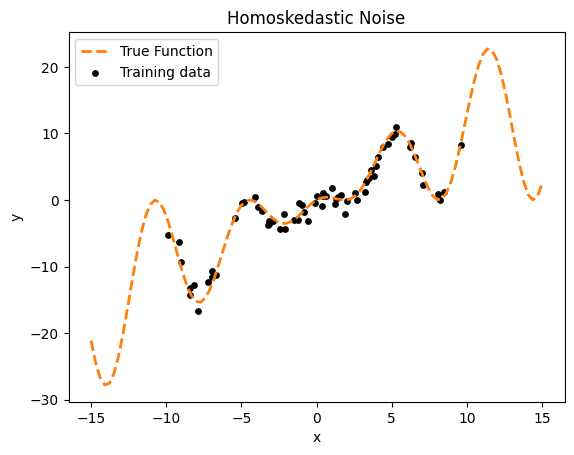

In [4]:
# Plot the ground truth function and the training data.
# For the sake of visualization clarity, only plot every 3rd data point.
plt.plot(
    X, y, linewidth=2, label="True Function", color="tab:orange", linestyle="dashed"
)
plt.scatter(
    X_data[::3], y_data_homoskedastic[::3], label="Training data", color="k", s=15
)
plt.legend()
plt.xlabel("x")
plt.ylabel("y")
plt.title("Homoskedastic Noise")
plt.show()

You have now defined the training data and noise dataframes. The next step is to upload these to `twinLab` cloud so you can train your emulator.


In [5]:
# Define the name of the dataset
dataset_id = "ObsNoise_Data"

# Upload the dataset to the cloud
dataset = tl.Dataset(dataset_id)
dataset.upload(df)

# Define the name of the std dataset
std_dataset_id = "ObsNoise_STD_Data"

# Upload the dataset to the cloud
std_dataset = tl.Dataset(std_dataset_id)
std_dataset.upload(df_stdev)

### **2. Train emulator and plot predictions using trained emulator**

In `twinlab`, a homoskedastic GP model is exposed via the keyword argument `estimator_type="single_task_gp"` which must be provided to the `EstimatorParams` within the `TrainParams` object during initialisation.

Additionally, the standard deviation of the observation noise can be provided to the `TrainParams` object as a dataframe. This additional dataframe must contain the same output columns as your training data. Since the observation noise is homoskedastic, the standard deviation of the noise must have the same value everywhere.


In [6]:
# Initialise emulator
emulator_id = "HomoskedasticGP"
emulator = tl.Emulator(emulator_id)

# Define the training and estimator parameters
estimator_params = tl.EstimatorParams(estimator_type="single_task_gp")
params = tl.TrainParams(dataset_std=std_dataset, estimator_params=estimator_params)

# Begin training the emulator
emulator.train(dataset, ["x"], ["y"], params)

Emulator 'HomoskedasticGP' has begun training.
0:00:00: Job status: processing
0:00:01: Job status: processing
0:00:03: Job status: processing
0:00:06: Job status: processing
0:00:08: Job status: processing
0:00:11: Job status: success
Training of emulator HomoskedasticGP is complete!


You can now plot the mean predictions and the standard deviation on the predictions of the trained emulator using `Emulator.plot` function in `twinLab`.


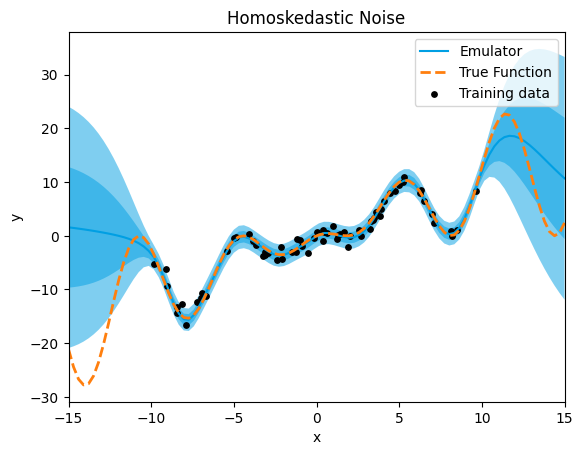

In [7]:
# Plot mean predictions and the standard deviation on the predictions
plt = emulator.plot(x_axis="x", y_axis="y", x_lim=(-15, 15))
# Plot the ground truth function
plt.plot(
    X, y, linewidth=2, label="True Function", color="tab:orange", linestyle="dashed"
)
# Plot the training data
# For the sake of visualization clarity, only plot every 3rd data point.
plt.scatter(
    X_data[::3], y_data_homoskedastic[::3], label="Training data", color="k", s=15
)
plt.title("Homoskedastic Noise")
plt.legend()
plt.show()

### **3. Generate and upload data with heteroskedastic noise**

For this example, you will use the same oscillator function to generate the training data. But, the fundamental difference will be in the noise generation process. The additive noise in this case will depend on the input data.

You can now also create a noise dataframe which contains information about the scaling factor that is multiplied with the base noise generated from a normal distribution.


In [8]:
noise_scale = 0.5

# Add heteroskedastic noise to data (note the multiplication by X_data)
y_data_heteroskedastic = (
    y_data + np.random.normal(scale=noise_scale, size=X_data.shape[0]) * X_data * 2
)

# Convert to dataframe
df = pd.DataFrame({"x": X_data, "y": y_data_heteroskedastic})

# Generate observation noise dataframe
df_stdev = pd.DataFrame({"y": X_data * 2})

You can now plot the training data and the ground truth function for visualization.


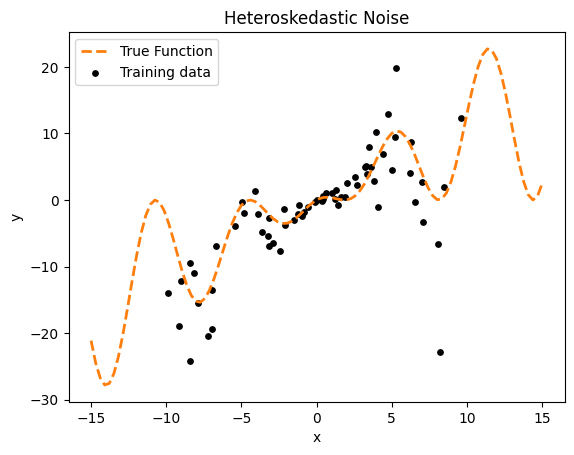

In [9]:
# Plot the ground truth function
# For the sake of visualization clarity, only plot every 3rd data point.
plt.plot(
    X, y, linewidth=2, label="True Function", color="tab:orange", linestyle="dashed"
)
# Plot the training data
plt.scatter(
    X_data[::3], y_data_heteroskedastic[::3], label="Training data", color="k", s=15
)
plt.legend()
plt.xlabel("x")
plt.ylabel("y")
plt.title("Heteroskedastic Noise")
plt.show()

You can now upload both the training data and the noise dataframe to the `twinLab` cloud for training your emulator.


In [10]:
# Define the name of the dataset
dataset_id = "ObsNoise_Data"

# Upload the dataset to the cloud
dataset = tl.Dataset(dataset_id)
dataset.upload(df)

# Define the name of the std dataset
std_dataset_id = "ObsNoise_STD_Data"

# Upload the dataset to the cloud
std_dataset = tl.Dataset(std_dataset_id)
std_dataset.upload(df_stdev)

### **4. Train heteroskedastic emulator and plot predictions using trained emulator**

In `twinlab`, a heteroskedastic GP model is exposed via the keyword argument `estimator_type="heteroskedastic_gp"` which must be provided to the `EstimatorParams` object within the `TrainParams` object during initialisation.

For this particular estimator type, the noise dataframe is a mandatory argument. It requires a noise dataframe for the training process. You can pass the noise dataframe to the `TrainParams` object through the `dataset_std` argument.


In [11]:
# Initialise emulator
emulator_id = "HeteroskedasticGP"
emulator = tl.Emulator(emulator_id)

# Define the training and estimator parameters
estimator_params = tl.EstimatorParams(estimator_type="heteroskedastic_gp")
params = tl.TrainParams(dataset_std=std_dataset, estimator_params=estimator_params)

# Begin training the emulator
emulator.train(dataset, ["x"], ["y"], params)

Emulator 'HeteroskedasticGP' has begun training.
0:00:00: Job status: processing
0:00:01: Job status: success
Training of emulator HeteroskedasticGP is complete!


Plot the mean predictions and the standard deviation on these predictions using the `Emulator.plot` function.


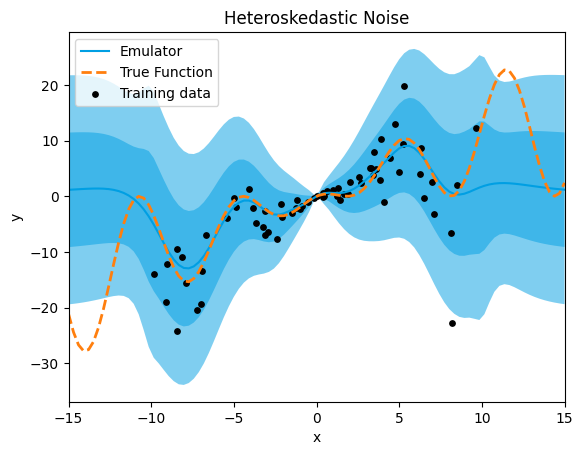

In [12]:
# Plot mean predictions and the standard deviation on the predictions
plt = emulator.plot(x_axis="x", y_axis="y", x_lim=(-15, 15))
# Plot the ground truth function
plt.plot(
    X, y, linewidth=2, label="True Function", color="tab:orange", linestyle="dashed"
)
# Plot the training data
# For the sake of visualization clarity, only plot every 3rd data point.
plt.scatter(
    X_data[::3], y_data_heteroskedastic[::3], label="Training data", color="k", s=15
)
plt.title("Heteroskedastic Noise")
plt.legend()
plt.show()

### **5. Delete trained emulators and datasets**

You can delete your datasets and emulators to keep your twinLab cloud account storage tidy.

Please be aware that this is permanent. Always consider keeping your data locally backed up.

`Emulator.delete` and `Dataset.delete` delete the emulator and the dataset respectively.


In [13]:
# Loop over the emulators trained in this tutorial
for emulator_i in ["HomoskedasticGP", "HeteroskedasticGP"]:
    # Delete the emulator
    tl.Emulator(emulator_i).delete()
# Delete the datasets
dataset.delete()
std_dataset.delete()

In this tutorial, you have seen how noisy data can be handled with `single_task_gp` and `heteroskedastic_gp` emulators for homoskedastic and heteroskedastic noise respectively in `twinLab`. Noisy data is very common in engineering, and an effective mechanism to account for the noise in the observations is a crucial aspect of engineering when modelling noisy data.

With `twinLab` this is straightforward and can be done by modifying just one single parameter, namely the `estimator_type`. This can significantly reduce the complexity of your engineering workflow making it easier to deploy trustworthy machine learning models that operate on your noisy data.
